<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import date

start_date = '20040101'
end_date = date.today().strftime("%Y%m%d")

In [2]:
# kospi = 'indTpCd' : '1',
# kosdaq = 'indTpCd' : '2',
import requests

otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
otp = requests.post(otp_url, data={'indTpCd' : '1',
                                   'indTpCd2' : '001',
                                   'strtDd' : start_date,
                                   'endDd' : end_date,
                                   'url' : 'dbms/MDC/STAT/standard/MDCSTAT00702'}).content

In [3]:
download_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
download = requests.post(download_url, data={'code': otp}).content

In [4]:
import pandas as pd
import numpy as np
import io

df = pd.read_csv(io.BytesIO(download), encoding='cp949')

In [5]:
df['date'] = pd.to_datetime(df['일자'])
df = df.rename(columns={'종가':'close', '등락률':'change', '배당수익률':'dividend'})
df = df.drop(['일자', '대비', '선행 PER'], axis=1)
df = df[::-1]
df = df.set_index('date')

df = df.replace(0, np.nan)
df = df.dropna()

In [6]:
df

,close,change,PER,PBR,dividend
date,,,,,
2004-01-02,821.26,1.30,10.20,1.03,2.06
2004-01-05,824.10,0.35,10.24,1.04,2.06
2004-01-06,823.43,-0.08,10.23,1.04,2.06
2004-01-07,827.07,0.44,10.28,1.05,2.04
2004-01-08,824.15,-0.35,10.24,1.04,2.05
...,...,...,...,...,...
2022-03-04,2713.43,-1.22,12.39,1.11,1.88
2022-03-07,2651.31,-2.29,12.10,1.08,1.92
2022-03-08,2622.40,-1.09,11.97,1.07,1.94


In [7]:
df.describe()

,close,change,PER,PBR,dividend
count,4476.000000,4476.000000,4476.000000,4476.000000,4476.000000
mean,1875.742864,0.034578,14.845563,1.195494,1.618284
std,527.935250,1.252916,4.665136,0.210043,0.399646
min,719.590000,-10.570000,7.370000,0.590000,1.000000
25%,1577.880000,-0.520000,11.790000,1.080000,1.320000
50%,1950.645000,0.070000,14.250000,1.160000,1.530000
75%,2094.552500,0.670000,16.135000,1.300000,1.840000
max,3305.210000,11.950000,33.350000,1.900000,3.150000


**PBR/PER**

In [8]:
import matplotlib.pyplot as plt
from scipy import stats

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def plot_hist(df, element):
  # colormap
  # matplotlib.cm.cmap_d.keys()
  cm = plt.cm.get_cmap('plasma')

  # Get the histogramp
  data = df[df[element] != 0][element]
  Y,X = np.histogram(data, 25)
  x_span = X.max()-X.min()
  C = [cm(((x-X.min())/x_span)) for x in X]

  plt.subplots(figsize=(7, 7))
  plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])

  # highlight
  height = Y[list(X).index(find_nearest(X, df.iloc[-1][element]))]
  width = (X[1]-X[0])/len(X)
  plt.bar(df.iloc[-1][element], height = height,  width=width, color = 'red')
  plt.show()

Pbr/Per Histogram

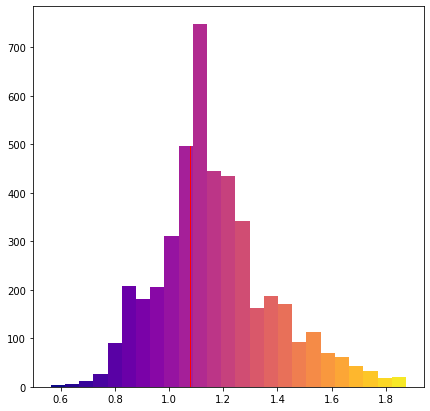

In [9]:
plot_hist(df, 'PBR')

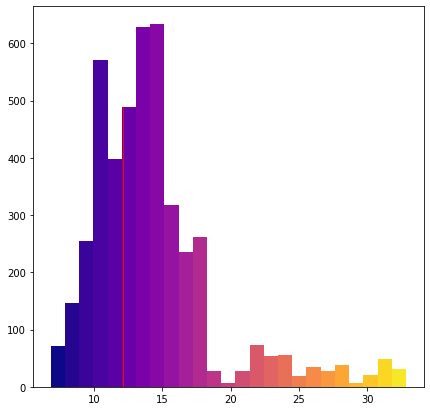

In [10]:
plot_hist(df, 'PER')

Pbr/Per position

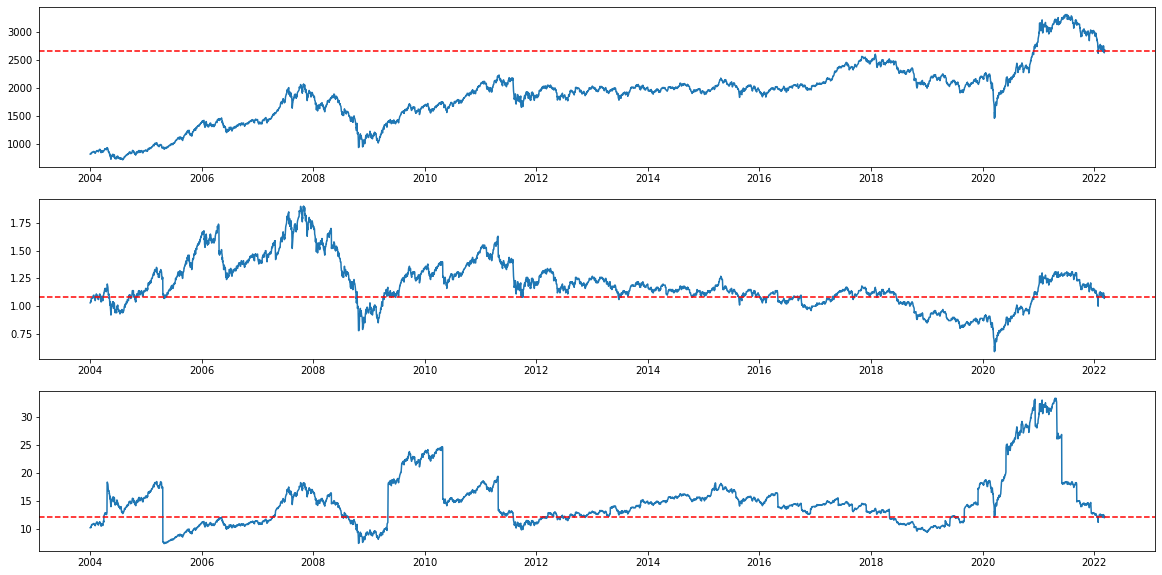

In [11]:
fig, axs = plt.subplots(3, figsize=(20,10))
axs[0].plot(df['close'])
axs[0].axhline(y = df.iloc[-1]['close'], color = 'r', linestyle = '--')
axs[1].plot(df['PBR'])
axs[1].axhline(y = df.iloc[-1]['PBR'], color = 'r', linestyle = '--')
axs[2].plot(df['PER'])
axs[2].axhline(y = df.iloc[-1]['PER'], color = 'r', linestyle = '--')
plt.show()

Pbr Band

In [12]:
pbr_band = {}
bands = [0.75, 1.0, 1.75]
for b in bands:
  pbr_band[b] = df['close']/(b*df['PBR'])

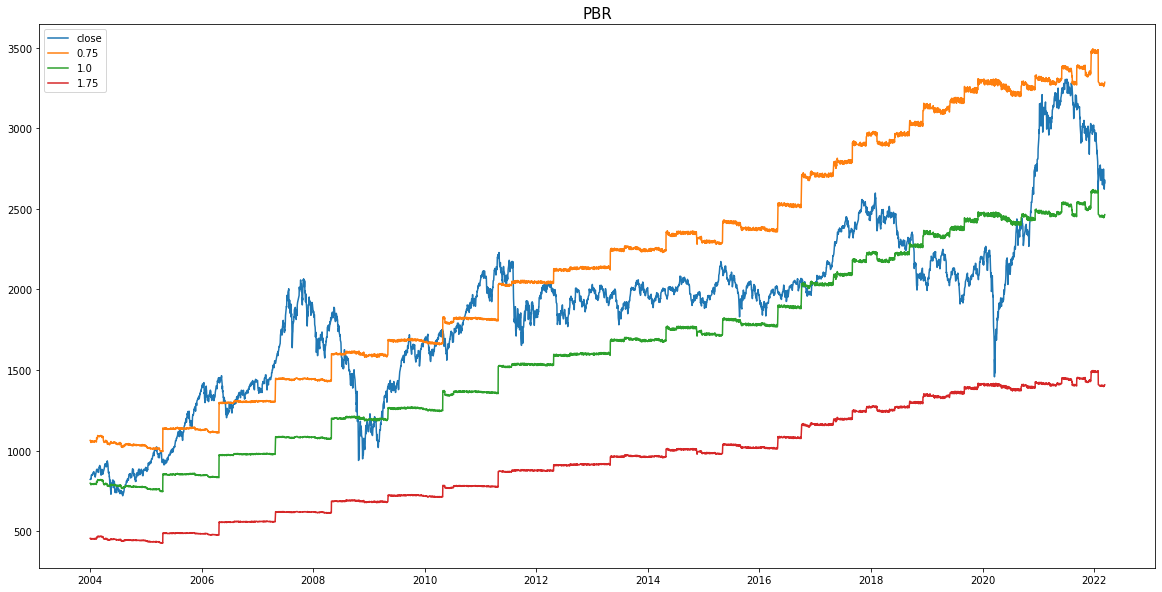

In [13]:
plt.figure(figsize=(20,10))
plt.title('PBR', fontsize=15)
plt.plot(df['close'])
for b in bands:
  plt.plot(pbr_band[b])
plt.legend(['close']+ bands)
plt.show()

**Moving Average**

In [14]:
ma20 = df['close'].rolling(20).mean()
ma60 = df['close'].rolling(60).mean()
ma120 = df['close'].rolling(120).mean()
ma240 = df['close'].rolling(240).mean()
ma480 = df['close'].rolling(480).mean()

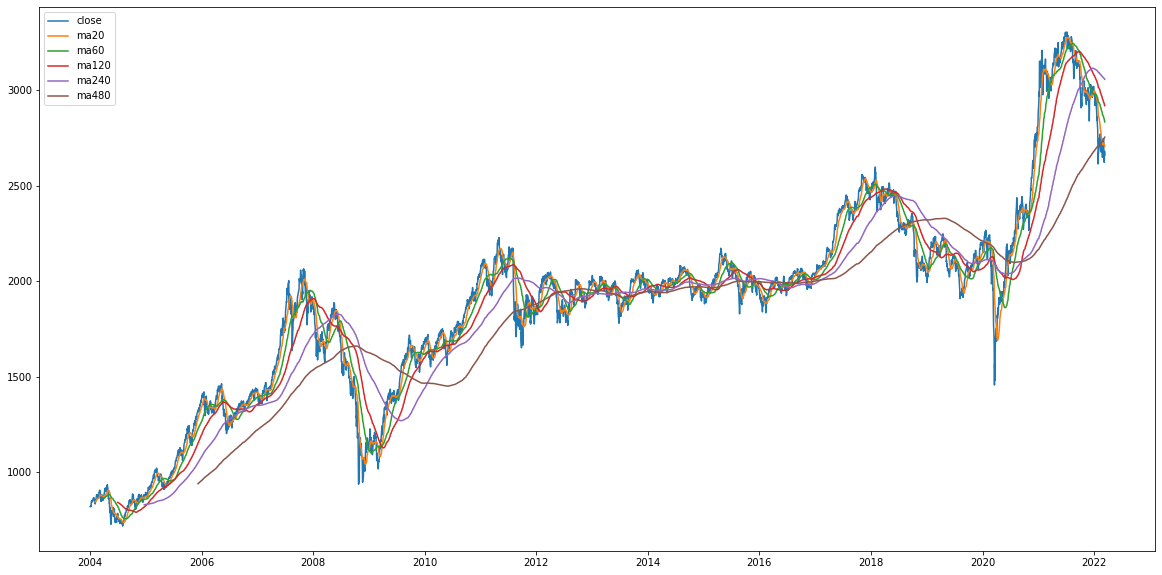

In [15]:
plt.figure(figsize=(20,10))
plt.plot(df['close'])
plt.plot(ma20)
plt.plot(ma60)
plt.plot(ma120)
plt.plot(ma240)
plt.plot(ma480)
plt.legend(['close', 'ma20', 'ma60', 'ma120', 'ma240', 'ma480'])
plt.show()

Distance from Moving Average

In [16]:
print('Ma20:  ', df['close'][-1]/ma20[-1])
print('Ma60:  ', df['close'][-1]/ma60[-1])
print('Ma120: ', df['close'][-1]/ma120[-1])
print('Ma240: ', df['close'][-1]/ma240[-1])

Ma20:   0.9839619249387399
Ma60:   0.9389446751279227
Ma120:  0.9115750226064345
Ma240:  0.8704308923684473


**MDD**

In [17]:
import datetime

def get_mdd(now=end_date, days=365):
  df_ = pd.DataFrame(df, index = pd.date_range(start=start_date, end=now)).fillna(method='ffill').dropna()[-days:]
  window = 20
  max_in_window = df_['close'].rolling(window, min_periods=1).max()
  dd = (df_['close']/max_in_window-1)*100
  mdd = dd.rolling(window, min_periods=1).min()
  return dd, mdd

In [18]:
dd, mdd = get_mdd()

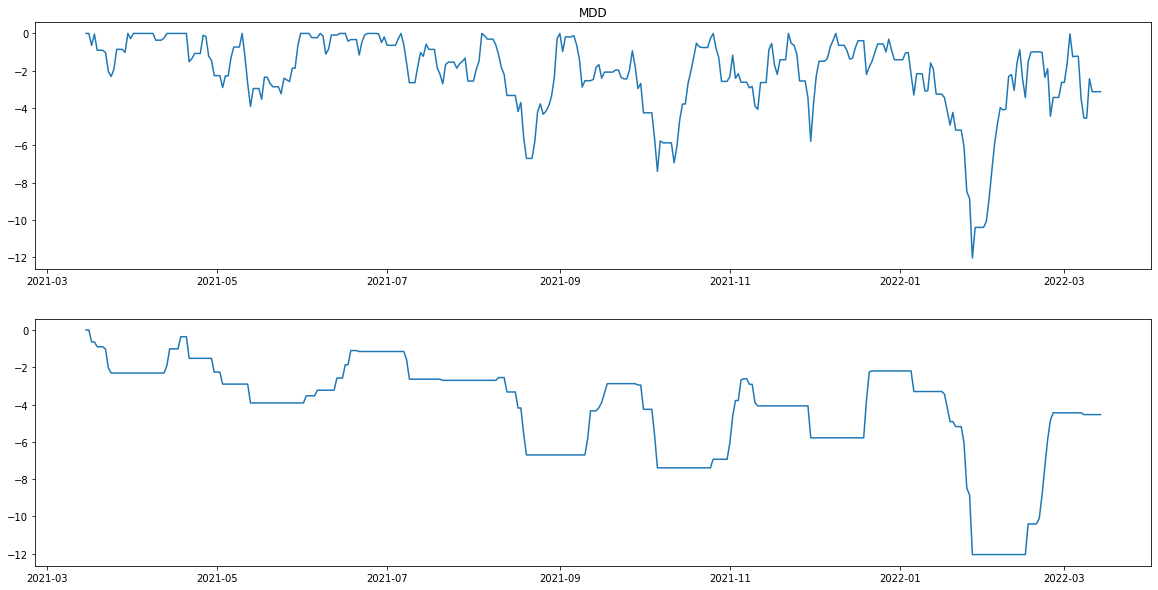

In [19]:
fig, axs = plt.subplots(2, figsize=(20,10))
axs[0].title.set_text('MDD')
axs[0].plot(dd)
axs[1].plot(mdd)
plt.show()

In [20]:
mdd.min()

-12.043478845946831